In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import requests
from lxml.html import parse

from urllib.request import urlopen
from pandas.io.parsers import TextParser
import struct
print('Libraries imported.')

Libraries imported.


In [4]:
round = 2

In [46]:
#read pre-processed data
house_price = pd.read_csv("house_price_relabled.csv")
house_price = house_price.rename(columns={"Lat":"Latitude","Long":"Longitude"})
house_price.head()

,Price Cluster Labels,Price,Latitude,Longitude
0,2,2150,43.643051,-79.391643
1,4,1950,43.660605,-79.378635
2,4,1800,43.652487,-79.389622
3,3,1729,43.634890,-79.434654
4,4,1900,43.640918,-79.393982


In [10]:
#read pre-processed data
criminal_record = pd.read_csv("with_fatal.csv")
criminal_record = criminal_record.rename(columns={"LATITUDE":"Latitude","LONGITUDE":"Longitude"})
criminal_record.head()

,ACCNUM,Latitude,Longitude,District,FATAL,District Label
0,1249781,43.651545,-79.383490,Toronto East York,0,1
1,1311542,43.780445,-79.300490,Scarborough,0,0
2,5002235651,43.682342,-79.328266,Toronto East York,1,1
3,1311542,43.780445,-79.300490,Scarborough,0,0
4,1311542,43.780445,-79.300490,Scarborough,0,0


/home/jupyterlab/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


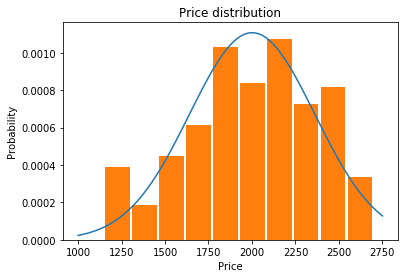

In [56]:
#price distribution
price = merge["Price"]
mean = price.mean()
std = price.std()

def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf


x = np.arange(1000,2750,0.1) 

y = normfun(x, mean, std)
plt.plot(x,y)

plt.hist(price, bins=10, rwidth=0.9, normed=True)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Probability')
#plot
plt.show()

In [50]:
#price cluster average
price_result = pd.DataFrame(columns=('cluster id','size','average',))
for cluster in range(5):
    size = len(house_price.loc[house_price['Price Cluster Labels'] == cluster])
    average = house_price.loc[house_price['Price Cluster Labels'] == cluster]['Price'].mean()
    print("Price cluster "+str(cluster)+" is size of "+str(size)+" with average price: "+str(int(average)))
    row={'cluster id':int(cluster),'size':size,'average':int(average)}
    price_result.loc[cluster]=row

Price cluster 0 is size of 129 with average price: 2474
Price cluster 1 is size of 59 with average price: 1302
Price cluster 2 is size of 172 with average price: 2187
Price cluster 3 is size of 101 with average price: 1649
Price cluster 4 is size of 171 with average price: 1905


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


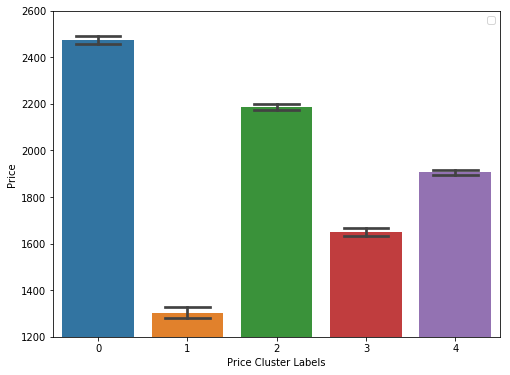

In [57]:
#price cluster analysis

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
plt.ylim(1200,2600)
sns.barplot(data = house_price,
            #hue = 'MONTH',
            x = 'Price Cluster Labels',
            # Number of events involving automobiles
            y = 'Price',
            capsize = 0.5)

# Legend Placement
plt.legend(loc='best')
# plt.legend(loc='upper right')
#plt.legend(loc='upper left')

plt.show()

In [16]:
#calculate fatal ratio

index = criminal_record[criminal_record['District Label']==0]
# len(index[index['FATAL']==1])/len(index)
print("Scarborough has fatal issue "+ str(len(index[index['FATAL']==1]))+" and fatal ratio "+ str(len(index[index['FATAL']==1])/len(index)) )
index = criminal_record[criminal_record['District Label']==1]
print("Toronto East York has fatal issue "+ str(len(index[index['FATAL']==1]))+" and fatal ratio "+ str(len(index[index['FATAL']==1])/len(index)) )
index = criminal_record[criminal_record['District Label']==2]
print("Etobicoke York has fatal issue "+ str(len(index[index['FATAL']==1]))+" and fatal ratio "+ str(len(index[index['FATAL']==1])/len(index)) )
index = criminal_record[criminal_record['District Label']==2]
print("North York York has fatal issue "+ str(len(index[index['FATAL']==1]))+" and fatal ratio "+ str(len(index[index['FATAL']==1])/len(index)) )

Scarborough has fatal issue 503 and fatal ratio 0.17108843537414967
Toronto East York has fatal issue 451 and fatal ratio 0.10738095238095238
Etobicoke York has fatal issue 379 and fatal ratio 0.12616511318242343
North York York has fatal issue 379 and fatal ratio 0.12616511318242343


In [19]:
#Classification on KSI data

feature_df = criminal_record[['Latitude', 'Longitude']]
X = np.asarray(feature_df)
#predict district label
y = np.asarray(criminal_record['District Label'])

In [22]:
#Split test/train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (10034, 2) (10034,)
Test set: (2509, 2) (2509,)


In [31]:
#Build model 

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
# make prediction and performance
yhat = clf.predict(X_test)
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       577
           1       0.91      0.98      0.95       869
           2       0.94      0.95      0.94       591
           3       0.98      0.74      0.84       472

   micro avg       0.93      0.93      0.93      2509
   macro avg       0.94      0.92      0.92      2509
weighted avg       0.93      0.93      0.93      2509



In [51]:
#apply model on house rental price dataset

house_geo = house_price[['Latitude', 'Longitude']]
house_price['District Label'] = clf.predict(house_geo)
house_price.sample(10)

,Price Cluster Labels,Price,Latitude,Longitude,District Label,District
108,1,1400.0,43.668468,-79.374834,1,Toronto East York
432,0,2600.0,43.638784,-79.398864,1,Toronto East York
210,4,1900.0,43.841361,-79.320149,0,Scarborough
16,3,1750.0,43.783190,-79.598567,2,Etobicoke York
559,3,1700.0,43.827583,-79.091381,0,Scarborough
180,2,2200.0,43.652210,-79.370799,1,Toronto East York
148,0,2450.0,43.660269,-79.382800,1,Toronto East York
278,0,2400.0,43.641889,-79.383794,1,Toronto East York
151,4,1850.0,43.646944,-79.392397,1,Toronto East York
366,1,1300.0,44.079119,-80.201173,2,Etobicoke York


In [2]:
merge = house_price.copy()
merge.head()

,Price Cluster Labels,Price,Latitude,Longitude,District Label,District
0,2,2150.0,43.643051,-79.391643,1,Toronto East York
1,4,1950.0,43.660605,-79.378635,1,Toronto East York
2,4,1800.0,43.652487,-79.389622,1,Toronto East York
3,3,1729.0,43.634890,-79.434654,1,Toronto East York
4,4,1900.0,43.640918,-79.393982,1,Toronto East York


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


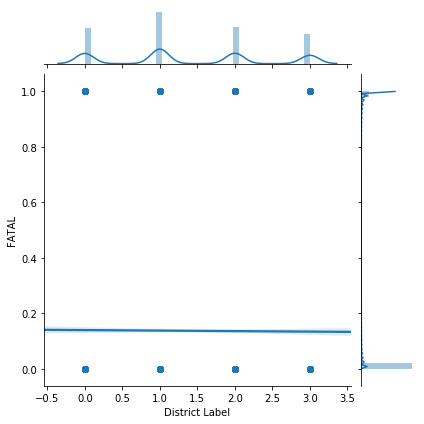

In [62]:
sns.jointplot(data = criminal_record,
              kind = 'reg',
              y = 'FATAL', 
              x = 'District Label') 
plt.show()

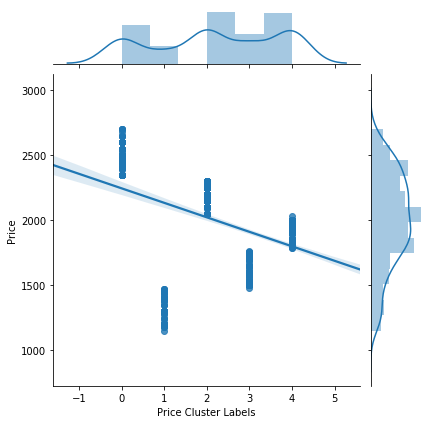

In [59]:

sns.jointplot(data = merge,
              kind = 'reg',
              y = 'Price', 
              x = 'Price Cluster Labels') 
plt.show()

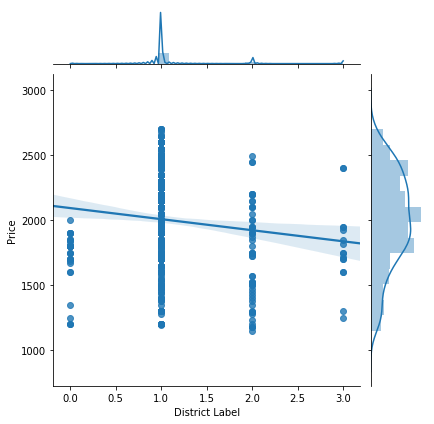

In [60]:
sns.jointplot(data = merge,
              kind = 'reg',
              y = 'Price', 
              x = 'District Label') 
plt.show()

In [63]:
#Draw the overlapped map

address = 'Toronto, CA'

geolocator = Nominatim(user_agent=None)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
colorx = pd.DataFrame({'color' : ['#d8b634', '#a2756c','#906ca1','#7da36d',]})
colory = pd.DataFrame({'color' : ['blue', 'yellow','red','green','purple']})




# create map

kclusters = 5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 2, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# x =  merge[merge['Price Cluster Labels'] == 8.0]
x = merge
# add markers to the map
markers_colors = []

for lat, lon, district_cluster in zip(x['Latitude'], x['Longitude'], x['District Label']):
    label = folium.Popup('Price Cluster ' + str(district_cluster), parse_html=True)
#     print("color "+str(colorx['color'][int(price_cluster)]))
    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=colorx['color'][int(district_cluster)],
        opacity =0.3,
        fill=True,
        fill_color=colorx['color'][int(district_cluster)],
        fill_opacity=0.3).add_to(map_clusters)


    
for lat2, lon2, price_cluster in zip(x['Latitude'], x['Longitude'], x['Price Cluster Labels']):
    label = folium.Popup('Criminal Cluster ' + str(price_cluster), parse_html=True)
   
    folium.CircleMarker(
        [lat2, lon2],
        radius=3,
        popup=label,
        color=colory['color'][int(price_cluster)],
        fill=True,
        fill_color=colory['color'][int(price_cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 43.653963, -79.387207.
